In [1]:
import numpy as np
import yfinance as yf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
etfs = ['DIA','IWM','SPY']
etfs.sort()
stocks = ['AMD', 'BRK-B','DIS','LAC','META','TSM','UAL']
stocks.sort()

n = len(stocks)
weight = 1/n

In [3]:
data = yf.download(stocks+etfs, period='11y')['Adj Close']

portfolio = (data[stocks].pct_change(252) * weight).sum(axis=1)
portfolio = portfolio.rename("Portfolio")
returns = pd.concat([data.pct_change(252), portfolio], axis = 1)

cov_matrix = returns[252:].cov(ddof=0)
corr_matrix = returns[252:].corr(method="pearson")

[*********************100%***********************]  10 of 10 completed


In [4]:
# FUNCTIONS

def drawdown(stock_close): # returns weekly drawdown
    weekly_data = stock_close.resample('7D').ffill() # borrowed from: https://www.codingfinance.com/post/2018-04-03-calc-returns-py/
    rolling_max = weekly_data.rolling(window=52,min_periods=1).max() # 52-week high
    return (weekly_data - rolling_max)/rolling_max # difference between current price and current max as ratio of current max

def beta(stock, index):
    return cov_matrix[stock][index]/cov_matrix[index][index]

In [5]:
# REQUIREMENT 1: CONSTITUENT STOCK RISK ANALYSIS

assets_df = pd.DataFrame(index = stocks)
assets_df['Portfolio_Weight'] = weight
assets_df['Annualized_Volatility'] = data[-63:].std()*(252**0.5)
#   --- https://www.investopedia.com/terms/b/beta.asp ---
#   Beta = cov(asset, index)/var(index) 
assets_df['Beta_Against_SPY'] = [beta(stock , 'SPY') for stock in stocks] # Function here for the sake of neatness
assets_df['Beta_Against_IWM'] = [beta(stock , 'IWM') for stock in stocks]
assets_df['Beta_Against_DIA'] = [beta(stock , 'DIA') for stock in stocks]
assets_df['Avg_Weekly_Drawdown'] = [(drawdown(data[stock])).mean() for stock in stocks]
assets_df['Max_Weekly_Drawdown'] = [(drawdown(data[stock])).min() for stock in stocks]
# --- www.corporatefinanceinstitute.com ---
#   Absolute return = (final price - initial price)/initial price 
#   Annualized Total return = (((final value/initial value)^(1/n)) - 1) 
assets_df['Total_Return'] = (data.iloc[-1] - data.iloc[252])/data.iloc[252]
assets_df['Annualized_Total_Return'] = ((data.iloc[-1]/data.iloc[252])**(1/10)) - 1
assets_df


,Portfolio_Weight,Annualized_Volatility,Beta_Against_SPY,Beta_Against_IWM,Beta_Against_DIA,Avg_Weekly_Drawdown,Max_Weekly_Drawdown,Total_Return,Annualized_Total_Return
AMD,0.142857,162.539861,1.560336,1.014608,1.938745,-0.234539,-0.771951,41.799128,0.455940
BRK-B,0.142857,88.550640,0.913656,0.531654,1.033983,-0.054624,-0.295699,1.964666,0.114802
DIS,0.142857,103.365677,1.509017,0.919664,1.445814,-0.105686,-0.493783,0.908887,0.066788
LAC,0.142857,32.685825,5.082192,2.993246,4.526098,-0.310391,-0.736111,20.760000,0.360711
META,0.142857,419.845024,1.980250,1.074995,1.652069,-0.134689,-0.731960,6.737861,0.227050
TSM,0.142857,86.241861,1.896046,1.110735,1.736350,-0.096409,-0.557372,6.510092,0.223389
UAL,0.142857,66.251270,1.523316,1.106655,1.901594,-0.172538,-0.744538,0.511787,0.042195


In [6]:
# REQUIREMENT 2: PORTFOLIO RISK VS ETFS

portfolio_against_etf_df = pd.DataFrame(index=etfs)
portfolio_against_etf_df['Corr_against_ETF'] = [corr_matrix['Portfolio'][etf] for etf in etfs]
portfolio_against_etf_df['Cov_against_ETF'] = [cov_matrix['Portfolio'][etf] for etf in etfs]
# --- https://www.investopedia.com/terms/t/trackingerror.asp ---
#   Tracking Error = std(portfolio_returns - benchmark returns)
portfolio_against_etf_df['Tracking_Errors'] = [(returns['Portfolio'][252:] - returns[etf][252:]).std() for etf in etfs]
# --- https://www.educba.com/sharpe-ratio-formula/ --- 
#   Sharpe Ratio = (expected rate of return of portfolio - risk free rate)/standard deviation of portfolio return
#   To be adjusted for interval used. Here, adjust by sqrt(252)
portfolio_against_etf_df['Sharpe_Ratio'] = [(((returns['Portfolio'][252:].mean() - returns[etf][252:].mean())/returns['Portfolio'][252:].std()) * (252**0.5)) for etf in etfs]
portfolio_against_etf_df['Ann_Volatility_Spread'] = [(((returns['Portfolio'][252:].std())*(252**0.5)) - ((returns[etf][252:].std())*(252**0.5))) for etf in etfs]
portfolio_against_etf_df


,Corr_against_ETF,Cov_against_ETF,Tracking_Errors,Sharpe_Ratio,Ann_Volatility_Spread
DIA,0.717969,0.031685,0.277384,9.347735,3.621655
IWM,0.771697,0.059538,0.230985,9.734673,2.137248
SPY,0.780084,0.036815,0.262535,8.793954,3.483989


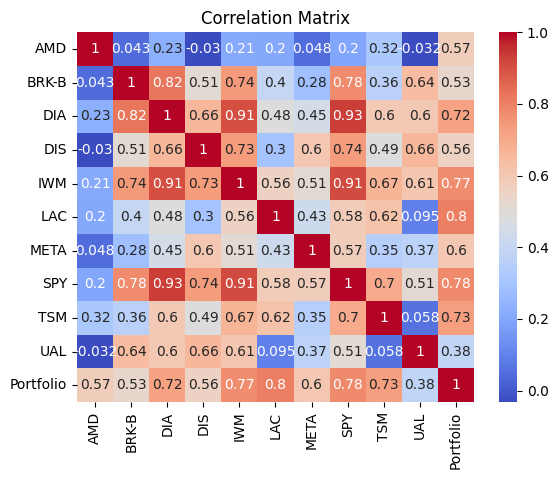

In [7]:
# REQUIREMENT NUMBER 3: CORRELATION MATRIX

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [8]:
assets_df = assets_df.style.set_caption('CONSTITUENT STOCK RISK ANALYSIS')
assets_df

,Portfolio_Weight,Annualized_Volatility,Beta_Against_SPY,Beta_Against_IWM,Beta_Against_DIA,Avg_Weekly_Drawdown,Max_Weekly_Drawdown,Total_Return,Annualized_Total_Return
AMD,0.142857,162.539861,1.560336,1.014608,1.938745,-0.234539,-0.771951,41.799128,0.455940
BRK-B,0.142857,88.550640,0.913656,0.531654,1.033983,-0.054624,-0.295699,1.964666,0.114802
DIS,0.142857,103.365677,1.509017,0.919664,1.445814,-0.105686,-0.493783,0.908887,0.066788
LAC,0.142857,32.685825,5.082192,2.993246,4.526098,-0.310391,-0.736111,20.760000,0.360711
META,0.142857,419.845024,1.980250,1.074995,1.652069,-0.134689,-0.731960,6.737861,0.227050
TSM,0.142857,86.241861,1.896046,1.110735,1.736350,-0.096409,-0.557372,6.510092,0.223389
UAL,0.142857,66.251270,1.523316,1.106655,1.901594,-0.172538,-0.744538,0.511787,0.042195


In [9]:
portfolio_against_etf_df = portfolio_against_etf_df.style.set_caption('PORTFOLIO RISK VS ETFS')
portfolio_against_etf_df

,Corr_against_ETF,Cov_against_ETF,Tracking_Errors,Sharpe_Ratio,Ann_Volatility_Spread
DIA,0.717969,0.031685,0.277384,9.347735,3.621655
IWM,0.771697,0.059538,0.230985,9.734673,2.137248
SPY,0.780084,0.036815,0.262535,8.793954,3.483989
